In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import librosa
import librosa.display
import math
import sys
#sys.path.insert(0,'/home/ikwak2/hmd/notebooks')
#sys.path.insert(0,'/home/ikwak2/hmd/iy_classifier')
sys.path.insert(0,'utils')
from helper_code import *
from get_feature import *
from models import *
from Generator0 import *

In [2]:
root_dir = 'physionet.org/files/circor-heart-sound/1.0.3'
training_data_file = root_dir + '/' + 'training_data.csv'
training_data_dir = root_dir + '/' + 'training_data'
model_dir = root_dir + '/' + 'model'

In [3]:
import tensorflow as tf

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Jul  7 15:00:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   41C    P0    42W / 300W |      2MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [5]:
data_folder =  'physionet.org/files/circor-heart-sound/1.0.3/training_data'
train_folder =  '/home/ubuntu/data/hmd/murmur/train'
test_folder = '/home/ubuntu/data/hmd/murmur/test'


In [6]:
model_folder = 'tmp_model4'

## Modeling

test 모형이 get_toy4_1, get_toy4_2 라고 하자

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [8]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start
    elif e > end:
        return lr_end

    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))

    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

In [9]:
model1 = get_toy4_1((100, 313, 1))
model2 = get_toy4_2((100, 313, 1))


In [10]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 49, 155, 16)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 45, 151, 32)  12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [11]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 100, 313, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 98, 311, 16)  160         mel[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 49, 155, 16)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 45, 151, 32)  12832       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

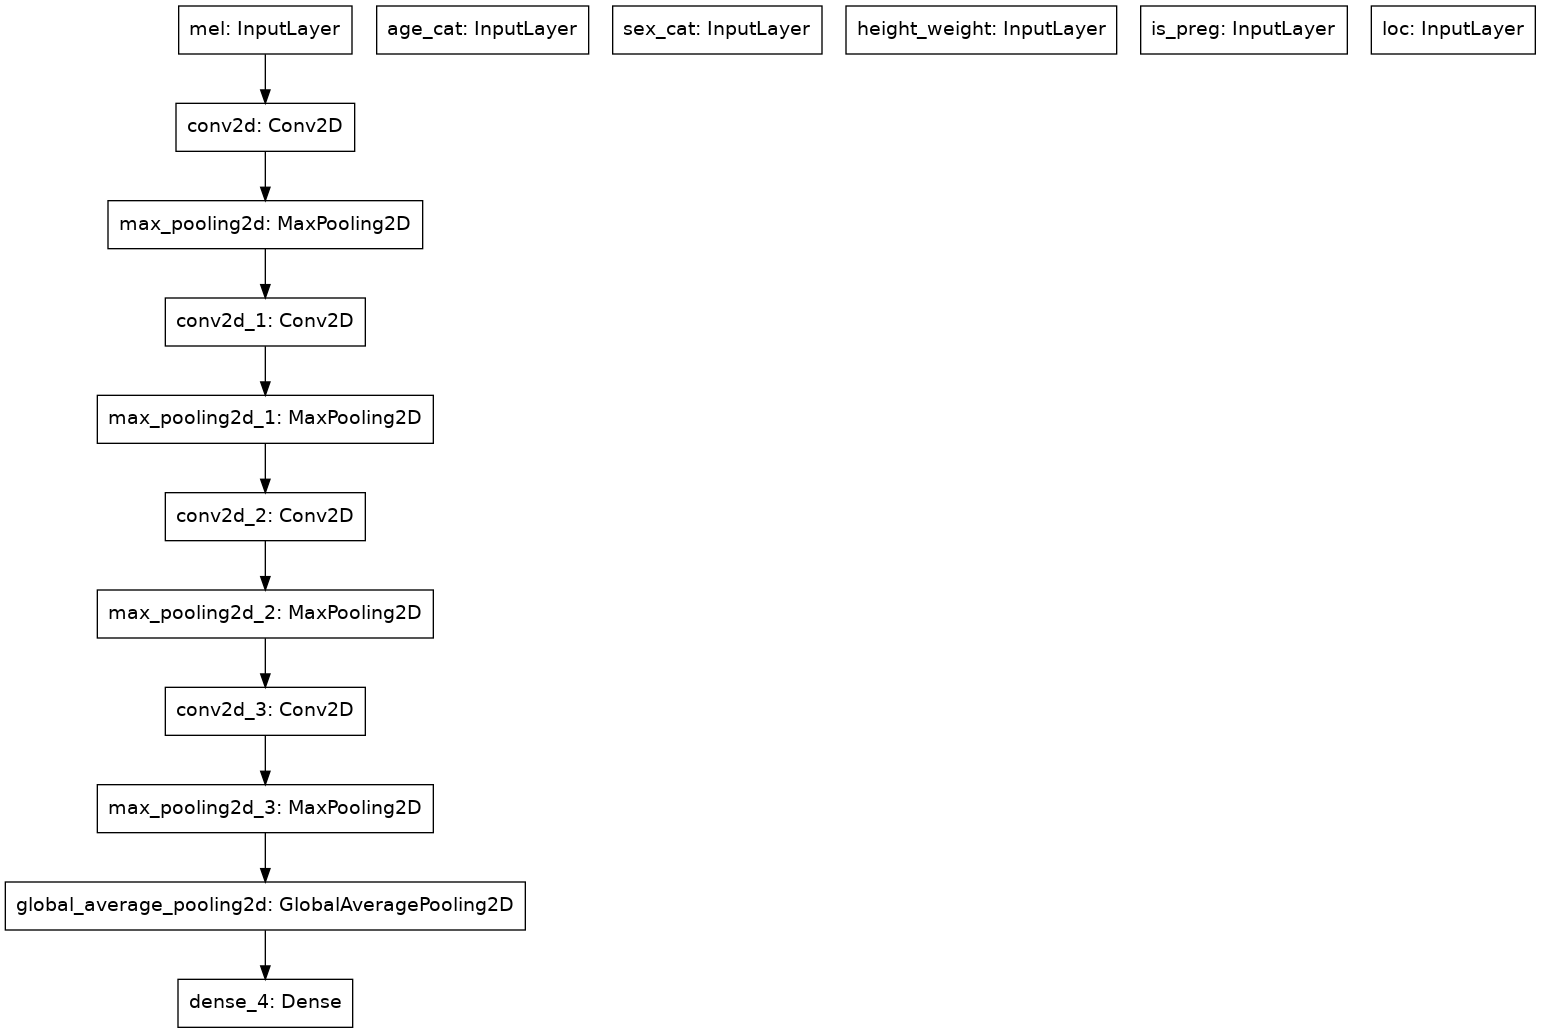

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png')

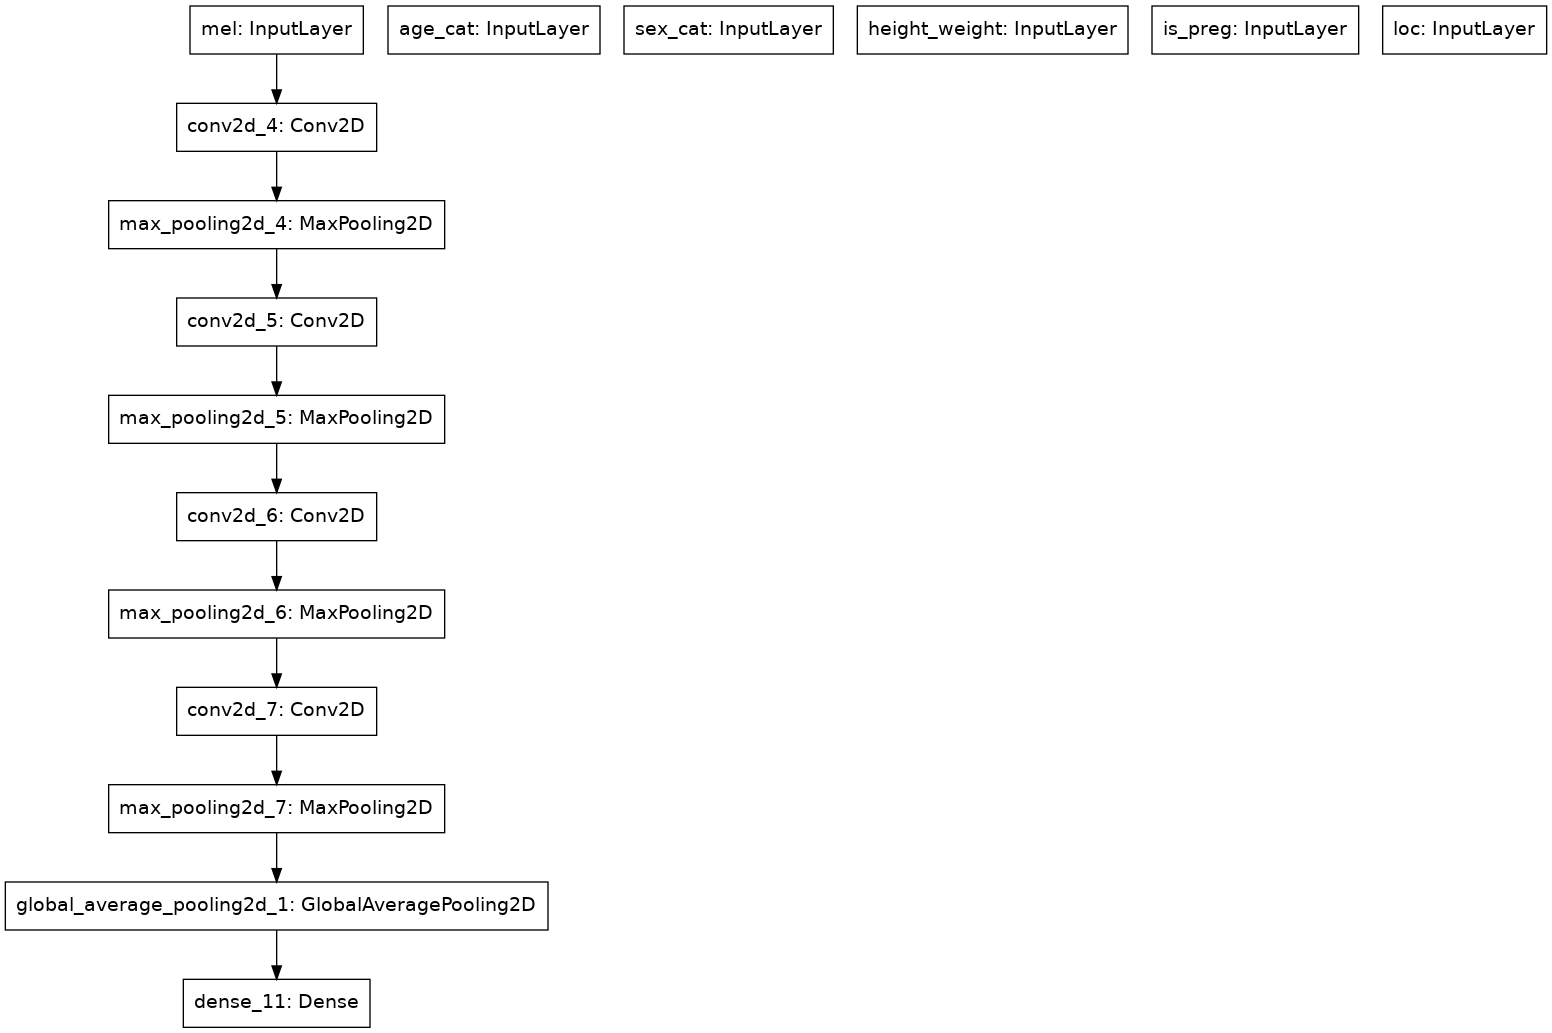

In [13]:
plot_model(model2, to_file='model.png')

In [14]:
patient_files = find_patient_files(data_folder)
patient_files_trn = find_patient_files(train_folder)
patient_files_test = find_patient_files(test_folder)

num_patient_files = len(patient_files)

In [15]:
features_trn = get_features_3lb(train_folder, patient_files_trn)
features_test = get_features_3lb(test_folder, patient_files_test)

In [16]:
n_epoch = 150
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
#          'highpass': [.5, [78,79,80,81,82,83,84,85]]
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[1],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[1],  ## our Y
                        **params_no_shuffle)()

    
model1.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[1]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 6s 60ms/step - loss: 1.3347 - accuracy: 0.6854 - val_loss: 0.5993 - val_accuracy: 0.7448
Epoch 2/100
40/40 [==============================] - 1s 37ms/step - loss: 0.5899 - accuracy: 0.7607 - val_loss: 0.5913 - val_accuracy: 0.7448
Epoch 3/100
40/40 [==============================] - 1s 37ms/step - loss: 0.5860 - accuracy: 0.7637 - val_loss: 0.5822 - val_accuracy: 0.7448
Epoch 4/100
40/40 [==============================] - 1s 34ms/step - loss: 0.5764 - accuracy: 0.7615 - val_loss: 0.5786 - val_accuracy: 0.7480
Epoch 5/100
40/40 [==============================] - 1s 36ms/step - loss: 0.5659 - accuracy: 0.7693 - val_loss: 0.5690 - val_accuracy: 0.7607
Epoch 6/100
40/40 [==============================] - 1s 33ms/step - loss: 0.5698 - accuracy: 0.7601 - val_loss: 0.5548 - val_accuracy: 0.7655
Epoch 7/100
40/40 [==============================] - 1s 34ms/step - loss: 0.5632 - accuracy: 0.7825 - val_loss: 0.5561 - val_accuracy: 0.7639
Epoch 

40/40 [==============================] - 1s 35ms/step - loss: 0.4338 - accuracy: 0.8624 - val_loss: 0.4054 - val_accuracy: 0.8510
Epoch 59/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4435 - accuracy: 0.8492 - val_loss: 0.4098 - val_accuracy: 0.8510
Epoch 60/100
40/40 [==============================] - 1s 35ms/step - loss: 0.4453 - accuracy: 0.8587 - val_loss: 0.4171 - val_accuracy: 0.8399
Epoch 61/100
40/40 [==============================] - 1s 34ms/step - loss: 0.4647 - accuracy: 0.8432 - val_loss: 0.4089 - val_accuracy: 0.8590
Epoch 62/100
40/40 [==============================] - 1s 32ms/step - loss: 0.4437 - accuracy: 0.8632 - val_loss: 0.4112 - val_accuracy: 0.8574
Epoch 63/100
40/40 [==============================] - 1s 37ms/step - loss: 0.4600 - accuracy: 0.8451 - val_loss: 0.4030 - val_accuracy: 0.8494
Epoch 64/100
40/40 [==============================] - 1s 35ms/step - loss: 0.4550 - accuracy: 0.8453 - val_loss: 0.4014 - val_accuracy: 0.8526
Epoch 65/100

In [17]:
n_epoch = 100
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=n_epoch))
batch_size = 64
params = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': True,
          'beta_param': 0.7,
          'mixup': True,
#          'lowpass': [.5, [11,12,13,14,15,16,17,18]]
          'highpass': [.5, [78,79,80,81,82,83,84,85]],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'batch_size': batch_size,
#          'input_shape': (100, 313, 1),
          'shuffle': False,
          'beta_param': 0.7,
          'mixup': False
          #'device': device
}

TrainDGen_1 = Generator0([features_trn[0]['age'],features_trn[0]['sex'], features_trn[0]['hw'], features_trn[0]['preg'], features_trn[0]['loc'], 
           features_trn[0]['mel1']], 
                        features_trn[2],  ## our Y
                        **params)()

ValDGen_1 = Generator0([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], features_test[0]['preg'], features_test[0]['loc'], 
           features_test[0]['mel1']], 
                        features_test[2],  ## our Y
                        **params_no_shuffle)()

    
model2.fit(TrainDGen_1,
          validation_data = ([features_test[0]['age'],features_test[0]['sex'], features_test[0]['hw'], 
                              features_test[0]['preg'], features_test[0]['loc'], features_test[0]['mel1']], 
                             features_test[2]), 
                             callbacks=[lr],
                              steps_per_epoch=np.ceil(len(features_trn[1])/64),
                             epochs = n_epoch)

Epoch 1/100
40/40 [==============================] - 2s 46ms/step - loss: 1.2134 - accuracy: 0.4917 - val_loss: 0.6831 - val_accuracy: 0.4992
Epoch 2/100
40/40 [==============================] - 1s 36ms/step - loss: 0.6948 - accuracy: 0.5240 - val_loss: 0.6690 - val_accuracy: 0.5357
Epoch 3/100
40/40 [==============================] - 2s 41ms/step - loss: 0.6839 - accuracy: 0.5468 - val_loss: 0.6504 - val_accuracy: 0.6450
Epoch 4/100
40/40 [==============================] - 2s 39ms/step - loss: 0.6851 - accuracy: 0.5499 - val_loss: 0.6630 - val_accuracy: 0.6276
Epoch 5/100
40/40 [==============================] - 1s 36ms/step - loss: 0.6879 - accuracy: 0.5547 - val_loss: 0.6520 - val_accuracy: 0.6482
Epoch 6/100
40/40 [==============================] - 2s 38ms/step - loss: 0.6820 - accuracy: 0.5473 - val_loss: 0.6293 - val_accuracy: 0.6482
Epoch 7/100
40/40 [==============================] - 2s 40ms/step - loss: 0.6806 - accuracy: 0.5509 - val_loss: 0.6360 - val_accuracy: 0.6418
Epoch 

40/40 [==============================] - 1s 34ms/step - loss: 0.6363 - accuracy: 0.6471 - val_loss: 0.6483 - val_accuracy: 0.6212
Epoch 59/100
40/40 [==============================] - 1s 35ms/step - loss: 0.6371 - accuracy: 0.6391 - val_loss: 0.6739 - val_accuracy: 0.5784
Epoch 60/100
40/40 [==============================] - 1s 37ms/step - loss: 0.6302 - accuracy: 0.6461 - val_loss: 0.6599 - val_accuracy: 0.6276
Epoch 61/100
40/40 [==============================] - 1s 34ms/step - loss: 0.6340 - accuracy: 0.6604 - val_loss: 0.6481 - val_accuracy: 0.6228
Epoch 62/100
40/40 [==============================] - 1s 36ms/step - loss: 0.6220 - accuracy: 0.6624 - val_loss: 0.6493 - val_accuracy: 0.6292
Epoch 63/100
40/40 [==============================] - 1s 34ms/step - loss: 0.6218 - accuracy: 0.6590 - val_loss: 0.6490 - val_accuracy: 0.6323
Epoch 64/100
40/40 [==============================] - 1s 33ms/step - loss: 0.6141 - accuracy: 0.6634 - val_loss: 0.6685 - val_accuracy: 0.5864
Epoch 65/100

### 팀코드 수정해야 할 함수들..

In [18]:
import pickle as pk
def save_challenge_model(model_folder, model1, model2, m_name1, m_name2, mel_shape = (100, 313, 1)) :
    os.makedirs(model_folder, exist_ok=True)
    info_fnm = os.path.join(model_folder, 'desc.pk')
    filename1 = os.path.join(model_folder, m_name1 + '_model1.hdf5')
    filename2 = os.path.join(model_folder, m_name2 + '_model2.hdf5')
    model1.save(filename1)
    model2.save(filename2)
    d = {'model1': m_name1, 'model2': m_name2, 'mel_shape': mel_shape, 'model_fnm1': filename1, 'model_fnm2': filename2}    
    with open(info_fnm, 'wb') as f:
        pk.dump(d, f, pk.HIGHEST_PROTOCOL)
    return 1
    

In [41]:
model_folder

'tmp_model4'

In [42]:
save_challenge_model(model_folder, model1, model2, m_name1 = 'toy1', m_name2 = 'toy2')

1

In [30]:
def load_challenge_model(model_folder, verbose):
    info_fnm = os.path.join(model_folder, 'desc.pk')
    with open(info_fnm, 'rb') as f:
        info_m = pk.load(f)
#    if info_m['model'] == 'toy' :
#        model = get_toy(info_m['mel_shape'])
#    filename = os.path.join(model_folder, info_m['model'] + '_model.hdf5')
#    model.load_weights(filename)
    return info_m

In [50]:
def run_challenge_model(model, data, recordings, verbose):
    
    murmur_classes = ['Present', 'Unknown', 'Absent']
    outcome_classes = ['Abnormal', 'Normal']
    
    if model['model1'] == 'toy1' :
        model1 = get_toy4_1(model['mel_shape'])
    if model['model2'] == 'toy2' :
        model2 = get_toy4_2(model['mel_shape'])
    model1.load_weights(model['model_fnm1'])
    model2.load_weights(model['model_fnm2'])
    
#    classes = model['classes']
    # Load features.
    features = get_feature_one(data, verbose = 0)

    features['mel1'] = []
    for i in range(len(recordings)) :
        mel1 = feature_extract_melspec(recordings[i]/ 32768)[0]
        features['mel1'].append(mel1)

    M, N = features['mel1'][0].shape
    for i in range(len(features['mel1'])) :
        features['mel1'][i] = features['mel1'][i].reshape(M,N,1)   
        
    features['mel1'] = np.array(features['mel1'])
#    print(features)
    # Impute missing data.
    res1 = model1.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])
    res2 = model2.predict([features['age'], features['sex'], features['hw'], features['preg'], features['loc'], features['mel1']])

    # Get classifier probabilities.
    idx1 = res1.argmax(axis=0)[0]
    murmur_probabilities = res1[idx1,]  ## mumur 확률 최대화 되는 애 뽑기
    outcome_probabilities = res2.mean(axis = 0) ##  outcome 은 그냥 평균으로 뽑기
    idx = np.argmax(prob1)

    ## 이부분도 생각 필요.. rule 을 cost를 maximize 하는 기준으로 threshold 탐색 필요할지도..
    # Choose label with highest probability.
    murmur_labels = np.zeros(len(murmur_classes), dtype=np.int_)
    idx = np.argmax(murmur_probabilities)
    murmur_labels[idx] = 1
    outcome_labels = np.zeros(len(outcome_classes), dtype=np.int_)
    idx = np.argmax(outcome_probabilities)
    outcome_labels[idx] = 1
    
    # Concatenate classes, labels, and probabilities.
    classes = murmur_classes + outcome_classes
    labels = np.concatenate((murmur_labels, outcome_labels))
    probabilities = np.concatenate((murmur_probabilities, outcome_probabilities))
    
    return classes, labels, probabilities

### 대회 평가용 run_model 함수 (수정 불필요)

In [32]:
# Run model.
def run_model(model_folder, data_folder, output_folder, allow_failures, verbose):
    # Load models.
    if verbose >= 1:
        print('Loading Challenge model...')

    model = load_challenge_model(model_folder, verbose) ### Teams: Implement this function!!!

    # Find the patient data files.
    patient_files = find_patient_files(data_folder)
    num_patient_files = len(patient_files)

    if num_patient_files==0:
        raise Exception('No data was provided.')

    # Create a folder for the Challenge outputs if it does not already exist.
    os.makedirs(output_folder, exist_ok=True)

    # Run the team's model on the Challenge data.
    if verbose >= 1:
        print('Running model on Challenge data...')

    # Iterate over the patient files.
    for i in range(num_patient_files):
        if verbose >= 2:
            print('    {}/{}...'.format(i+1, num_patient_files))

        patient_data = load_patient_data(patient_files[i])
        recordings = load_recordings(data_folder, patient_data)

        # Allow or disallow the model to fail on parts of the data; helpful for debugging.
        try:
            classes, labels, probabilities = run_challenge_model(model, patient_data, recordings, verbose) ### Teams: Implement this function!!!
        except:
            if allow_failures:
                if verbose >= 2:
                    print('... failed.')
                classes, labels, probabilities = list(), list(), list()
            else:
                raise

        # Save Challenge outputs.
        head, tail = os.path.split(patient_files[i])
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_folder, root + '.csv')
        patient_id = get_patient_id(patient_data)
        save_challenge_outputs(output_file, patient_id, classes, labels, probabilities)

    if verbose >= 1:
        print('Done.')

In [33]:
## 우리 모형 저장된 폴더이름
model_folder

'tmp_model4'

In [34]:
## 테스트 데이터 폴더
test_folder

'/home/ubuntu/data/hmd/murmur/test'

In [55]:
## 테스트 데이터에 모형 돌려서 스코어 저장할 폴더
output_folder = '/home/ubuntu/hmd/notebooks/out2'

이거 아래 돌아갈 때 뭔가 잘못된듯..? 디버깅 필요

In [56]:
run_model(model_folder, test_folder, output_folder, allow_failures = True, verbose = 1)

Loading Challenge model...
Running model on Challenge data...
Done.


In [64]:
!cat /home/ubuntu/hmd/notebooks/out1/49628.csv

#49628





뭔가  이상함.. 기록이 안되어있음

In [57]:
from evaluate_model import *

In [58]:
murmur_scores, outcome_scores = evaluate_model(test_folder, output_folder)
classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = murmur_scores
murmur_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
murmur_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

classes, auroc, auprc, auroc_classes, auprc_classes, f_measure, f_measure_classes, accuracy, accuracy_classes, weighted_accuracy, cost = outcome_scores
outcome_output_string = 'AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}\n'.format(auroc, auprc, f_measure, accuracy, weighted_accuracy, cost)
outcome_class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}\nAccuracy,{}\n'.format(
    ','.join(classes),
    ','.join('{:.3f}'.format(x) for x in auroc_classes),
    ','.join('{:.3f}'.format(x) for x in auprc_classes),
    ','.join('{:.3f}'.format(x) for x in f_measure_classes),
    ','.join('{:.3f}'.format(x) for x in accuracy_classes))

output_string = '#Murmur scores\n' + murmur_output_string + '\n#Outcome scores\n' + outcome_output_string \
    + '\n#Murmur scores (per class)\n' + murmur_class_output_string + '\n#Outcome scores (per class)\n' + outcome_class_output_string

if len(sys.argv) == 3:
    print(output_string)
elif len(sys.argv) == 4:
    with open(sys.argv[3], 'w') as f:
        f.write(output_string)

#Murmur scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.500,0.333,0.111,0.199,0.512,15140.890

#Outcome scores
AUROC,AUPRC,F-measure,Accuracy,Weighted Accuracy,Cost
0.500,0.500,0.339,0.513,0.840,15140.890

#Murmur scores (per class)
Classes,Present,Unknown,Absent
AUROC,0.500,0.500,0.500
AUPRC,0.199,0.073,0.728
F-measure,0.332,0.000,0.000
Accuracy,1.000,0.000,0.000

#Outcome scores (per class)
Classes,Abnormal,Normal
AUROC,0.500,0.500
AUPRC,0.513,0.487
F-measure,0.678,0.000
Accuracy,1.000,0.000



out 폴더에 기록 안되는 버그 수정 필요